In [1]:
import sys, os, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
os.chdir('game-behavior-analytics/data_analysis_notebook/')

In [16]:
# =============================================================================
# 1. DATA LOADING AND PREPARATION
# =============================================================================

sys.path.append(os.path.abspath('utils'))

warnings.filterwarnings('ignore')

# Now you can import the utility function
from data_utils import load_and_prepare_data
from metadata import theory_order, theory_map

# Load and preprocess your data
df, concepts = load_and_prepare_data("../data/final_dataset.csv")

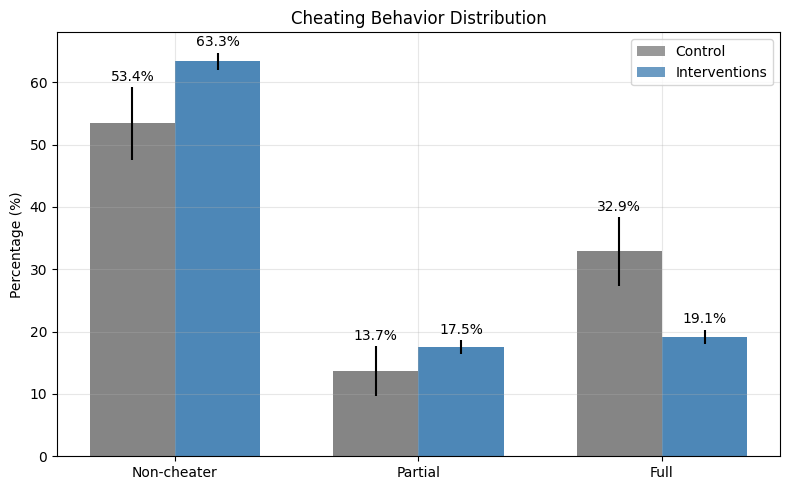

Control group (n=73):
Non-cheater: 53.4%, Partial: 13.7%, Full: 32.9%

Intervention groups (n=1159):
Non-cheater: 63.3%, Partial: 17.5%, Full: 19.1%


In [26]:
# =============================================================================
# DESCRIPTIVE PLOTS: CHEATING BEHAVIOR DISTRIBUTION
# =============================================================================

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

# Calculate proportions
cheat_counts = df.groupby(['concept', 'cheating_behavior']).size().unstack(fill_value=0)
cheat_props = cheat_counts.div(cheat_counts.sum(axis=1), axis=0) * 100

# Separate control vs interventions
control_props = cheat_props.loc['control']
intervention_props = cheat_props.drop('control').mean()

# Plot
x = np.arange(3)
width = 0.35
labels = ['Non-cheater', 'Partial', 'Full']

ax.bar(x - width/2, control_props, width, label='Control', alpha=0.8, color='gray')
ax.bar(x + width/2, intervention_props, width, label='Interventions', alpha=0.8, color='steelblue')

ax.set_ylabel('Percentage (%)')
ax.set_title('Cheating Behavior Distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(True, alpha=0.3)

# Calculate standard errors for proportions
control_n = len(df[df['concept'] == 'control'])
intervention_n = len(df[df['concept'] != 'control'])

ctrl_se = np.sqrt(control_props/100 * (1 - control_props/100) / control_n) * 100
interv_se = np.sqrt(intervention_props/100 * (1 - intervention_props/100) / intervention_n) * 100

ax.bar(x - width/2, control_props, width, label='Control', alpha=0.8, color='gray', yerr=ctrl_se)
ax.bar(x + width/2, intervention_props, width, label='Interventions', alpha=0.8, color='steelblue', yerr=interv_se)

# Add value labels
for i, (ctrl, interv) in enumerate(zip(control_props, intervention_props)):
    ax.text(i - width/2, ctrl + ctrl_se[i] + 1, f'{ctrl:.1f}%', ha='center', fontsize=10)
    ax.text(i + width/2, interv + interv_se[i] + 1, f'{interv:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"Control group (n={len(df[df['concept']=='control'])}):")
print(f"Non-cheater: {control_props[0]:.1f}%, Partial: {control_props[1]:.1f}%, Full: {control_props[2]:.1f}%")
print(f"\nIntervention groups (n={len(df[df['concept']!='control'])}):")
print(f"Non-cheater: {intervention_props[0]:.1f}%, Partial: {intervention_props[1]:.1f}%, Full: {intervention_props[2]:.1f}%")

In [3]:
# =============================================================================
# 2. RQ1: CHEATING BEHAVIOR MODEL
# =============================================================================

def build_cheating_model(df, concepts):
    with pm.Model() as model:
        # Intercepts
        beta_partial = pm.Normal('beta_partial_intercept', mu=0, sigma=1)
        beta_full = pm.Normal('beta_full_intercept', mu=0, sigma=1)

        # Concept-level partial cheating effects
        mu_partial = pm.Normal('mu_concept_partial', mu=0, sigma=1)
        sigma_partial = pm.HalfNormal('sigma_concept_partial', sigma=1)
        concept_partial = pm.Normal('concept_effects_partial', mu=mu_partial, sigma=sigma_partial, shape=len(concepts))

        # Concept-level full cheating effects
        mu_full = pm.Normal('mu_concept_full', mu=0, sigma=1)
        sigma_full = pm.HalfNormal('sigma_concept_full', sigma=1)
        concept_full = pm.Normal('concept_effects_full', mu=mu_full, sigma=sigma_full, shape=len(concepts))

        # Linear predictors by concept (0 = control)
        concept_idx = df['concept_idx'].values
        partial_effect = pm.math.switch(concept_idx > 0, concept_partial[concept_idx - 1], 0)
        full_effect = pm.math.switch(concept_idx > 0, concept_full[concept_idx - 1], 0)

        # Linear logits: [non, partial, full]
        logits = pm.math.stack([
            pm.math.zeros_like(partial_effect),         # baseline (non-cheater)
            beta_partial + partial_effect,
            beta_full + full_effect
        ], axis=1)

        probs = pm.math.softmax(logits, axis=1)

        pm.Categorical('cheating_observed', p=probs, observed=df['cheating_behavior'].values)

    return model


def sample_cheating_model(model, **kwargs):
    with model:
        trace = pm.sample(
            draws=kwargs.get("draws", 1500),
            tune=kwargs.get("tune", 2000),
            chains=kwargs.get("chains", 4),
            cores=kwargs.get("cores", 4),
            target_accept=kwargs.get("target_accept", 0.95),
            max_treedepth=kwargs.get("max_treedepth", 12),
            init=kwargs.get("init", "jitter+adapt_diag"),
            random_seed=kwargs.get("random_seed", 42)
        )
    return trace


In [4]:
print("Fitting RQ1: Cheating Behavior Model...")
cheating_model = build_cheating_model(df, concepts)
trace_cheating = sample_cheating_model(cheating_model)
print("Done.")

Fitting RQ1: Cheating Behavior Model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_partial_intercept, beta_full_intercept, mu_concept_partial, sigma_concept_partial, concept_effects_partial, mu_concept_full, sigma_concept_full, concept_effects_full]


Output()

Sampling 4 chains for 2_000 tune and 1_500 draw iterations (8_000 + 6_000 draws total) took 189 seconds.
There were 128 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Done.


In [24]:
az.to_netcdf(trace_cheating, "notebook/trace_cheating.nc")

'notebook/trace_cheating.nc'

In [5]:
with cheating_model:
    ppc_cheating_prior = pm.sample_prior_predictive(model=cheating_model)
    ppc_cheating_posterior = pm.sample_posterior_predictive(trace_cheating, random_seed=42)

Sampling: [beta_full_intercept, beta_partial_intercept, cheating_observed, concept_effects_full, concept_effects_partial, mu_concept_full, mu_concept_partial, sigma_concept_full, sigma_concept_partial]
Sampling: [cheating_observed]


Output()

<Axes: xlabel='cheating_observed'>

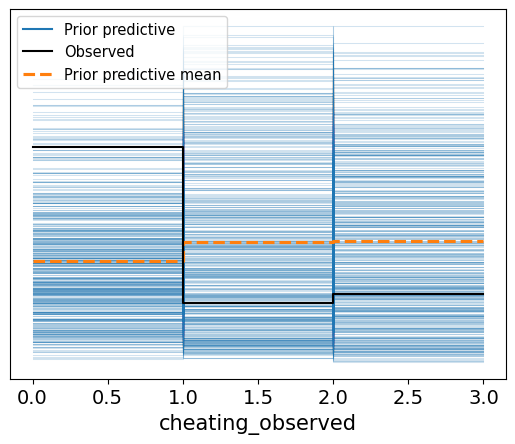

In [6]:
az.plot_ppc(ppc_cheating_prior, group='prior', observed=True)

<Axes: xlabel='cheating_observed'>

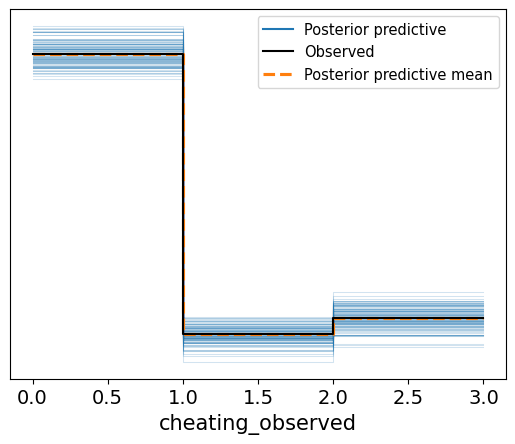

In [7]:
az.plot_ppc(ppc_cheating_posterior, num_pp_samples=100)

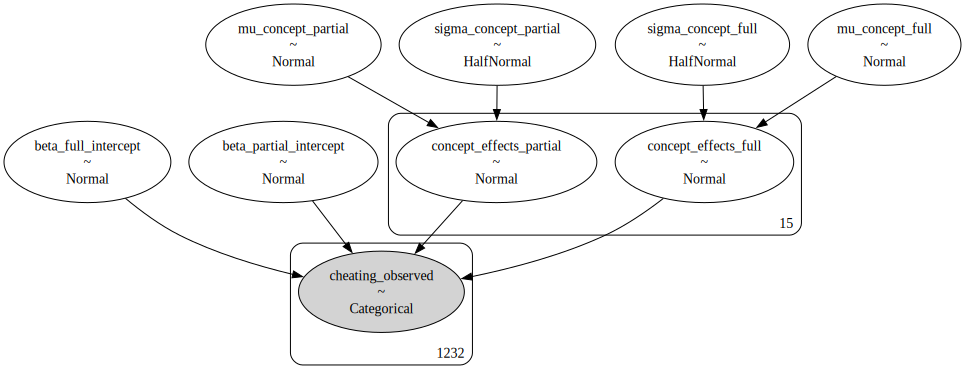

In [8]:
pm.model_to_graphviz(cheating_model)

In [12]:
# =============================================================================
# 3. RQ1 RESULTS: Posterior Extraction + Summary
# =============================================================================

def summarize_cheating_effects(trace, concepts, theory_order, theory_map):
    """Summarizes posterior changes in cheating behavior by concept."""
    
    # Extract posterior samples
    beta_partial = trace.posterior['beta_partial_intercept'].values.flatten()
    beta_full = trace.posterior['beta_full_intercept'].values.flatten()
    
    partial_effects = trace.posterior['concept_effects_partial'].values.reshape(-1, len(concepts))
    full_effects = trace.posterior['concept_effects_full'].values.reshape(-1, len(concepts))

    # Control group logits and probabilities
    control_logits = np.column_stack([
        np.zeros_like(beta_partial),  # logit for non-cheater baseline
        beta_partial,
        beta_full
    ])
    control_probs = np.exp(control_logits) / np.exp(control_logits).sum(axis=1, keepdims=True)

    # By-concept differences
    results = []
    for concept in theory_order:
        if concept not in concepts:
            continue
        idx = concepts.index(concept)

        concept_logits = np.column_stack([
            np.zeros_like(beta_partial),
            beta_partial + partial_effects[:, idx],
            beta_full + full_effects[:, idx]
        ])
        concept_probs = np.exp(concept_logits) / np.exp(concept_logits).sum(axis=1, keepdims=True)

        # Compute difference from control (percentage points)
        diffs = {
            'non': (concept_probs[:, 0] - control_probs[:, 0]) * 100,
            'partial': (concept_probs[:, 1] - control_probs[:, 1]) * 100,
            'full': (concept_probs[:, 2] - control_probs[:, 2]) * 100,
        }

        results.append({
            'Concept': concept.replace('_', ' ').title(),
            'Theory': theory_map[concept],
            'Non_mean': diffs['non'].mean(),
            'Non_hdi': az.hdi(diffs['non'], hdi_prob=0.95),
            'Partial_mean': diffs['partial'].mean(),
            'Partial_hdi': az.hdi(diffs['partial'], hdi_prob=0.95),
            'Full_mean': diffs['full'].mean(),
            'Full_hdi': az.hdi(diffs['full'], hdi_prob=0.95),
        })

    df_results = pd.DataFrame(results)

    # Overall average effect across all concepts
    overall_logits = np.column_stack([
        np.zeros_like(beta_partial),
        beta_partial + partial_effects.mean(axis=1),
        beta_full + full_effects.mean(axis=1)
    ])
    overall_probs = np.exp(overall_logits) / np.exp(overall_logits).sum(axis=1, keepdims=True)

    overall_effects = {}
    for i, label in enumerate(['Non', 'Partial', 'Full']):
        diff = (overall_probs[:, i] - control_probs[:, i]) * 100
        overall_effects[label] = {
            'mean': diff.mean(),
            'hdi': az.hdi(diff, hdi_prob=0.95)
        }

    control_rates = {
        'Non': control_probs[:, 0].mean() * 100,
        'Partial': control_probs[:, 1].mean() * 100,
        'Full': control_probs[:, 2].mean() * 100
    }

    return df_results, overall_effects, control_rates


In [13]:
def print_cheating_results_table(df_results):
    print("\nRQ1: CHEATING BEHAVIOR CHANGES (percentage points) with 95% HDI:")
    print(f"{'Concept':<35} {'Theory':<30} {'Non-cheater':<25} {'Partial':<25} {'Full':<25}")
    print("-" * 130)

    for _, row in df_results.iterrows():
        non = f"{row['Non_mean']:+.1f} [{row['Non_hdi'][0]:+.1f}, {row['Non_hdi'][1]:+.1f}]"
        partial = f"{row['Partial_mean']:+.1f} [{row['Partial_hdi'][0]:+.1f}, {row['Partial_hdi'][1]:+.1f}]"
        full = f"{row['Full_mean']:+.1f} [{row['Full_hdi'][0]:+.1f}, {row['Full_hdi'][1]:+.1f}]"
        print(f"{row['Concept']:<35} {row['Theory']:<30} {non:<25} {partial:<25} {full:<25}")


In [17]:
df_results_cheating, overall_results_cheating, control_rates = summarize_cheating_effects(trace_cheating, concepts, theory_order, theory_map)

print_cheating_results_table(df_results_cheating)


RQ1: CHEATING BEHAVIOR CHANGES (percentage points) with 95% HDI:
Concept                             Theory                         Non-cheater               Partial                   Full                     
----------------------------------------------------------------------------------------------------------------------------------
Autonomy                            Self-Determination Theory      +11.9 [+0.3, +22.4]       +2.9 [-5.0, +10.9]        -14.7 [-24.9, -2.4]      
Competence                          Self-Determination Theory      +11.9 [+0.9, +23.2]       +1.5 [-6.6, +9.4]         -13.5 [-23.4, -1.8]      
Relatedness                         Self-Determination Theory      +11.6 [+0.3, +22.3]       +1.4 [-6.7, +9.2]         -13.0 [-23.5, -1.5]      
Self Concept                        Cognitive Dissonance Theory    +11.6 [+0.9, +23.0]       +2.4 [-6.1, +9.7]         -14.0 [-25.0, -3.1]      
Cognitive Inconsistency             Cognitive Dissonance Theory    +12.0 [+0.1

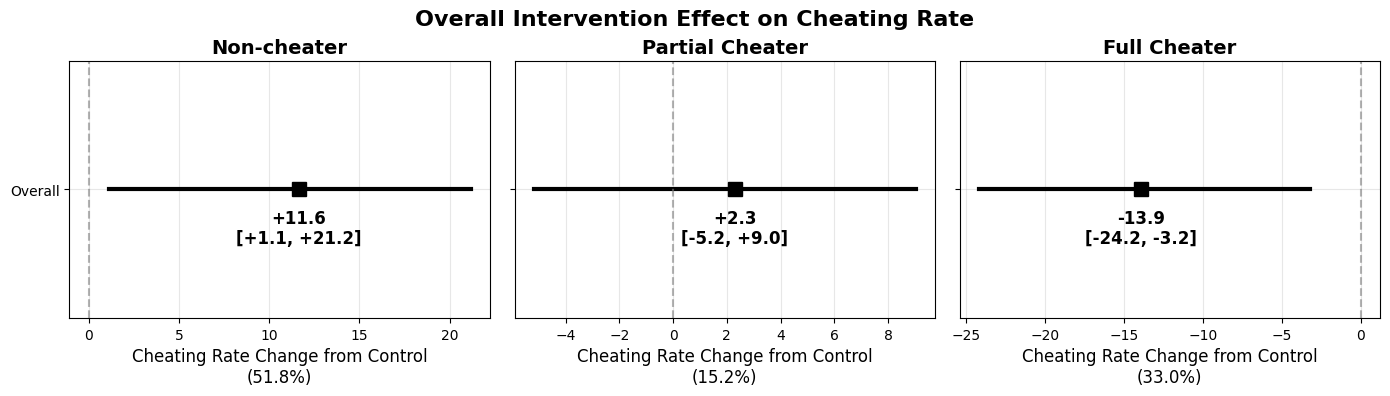

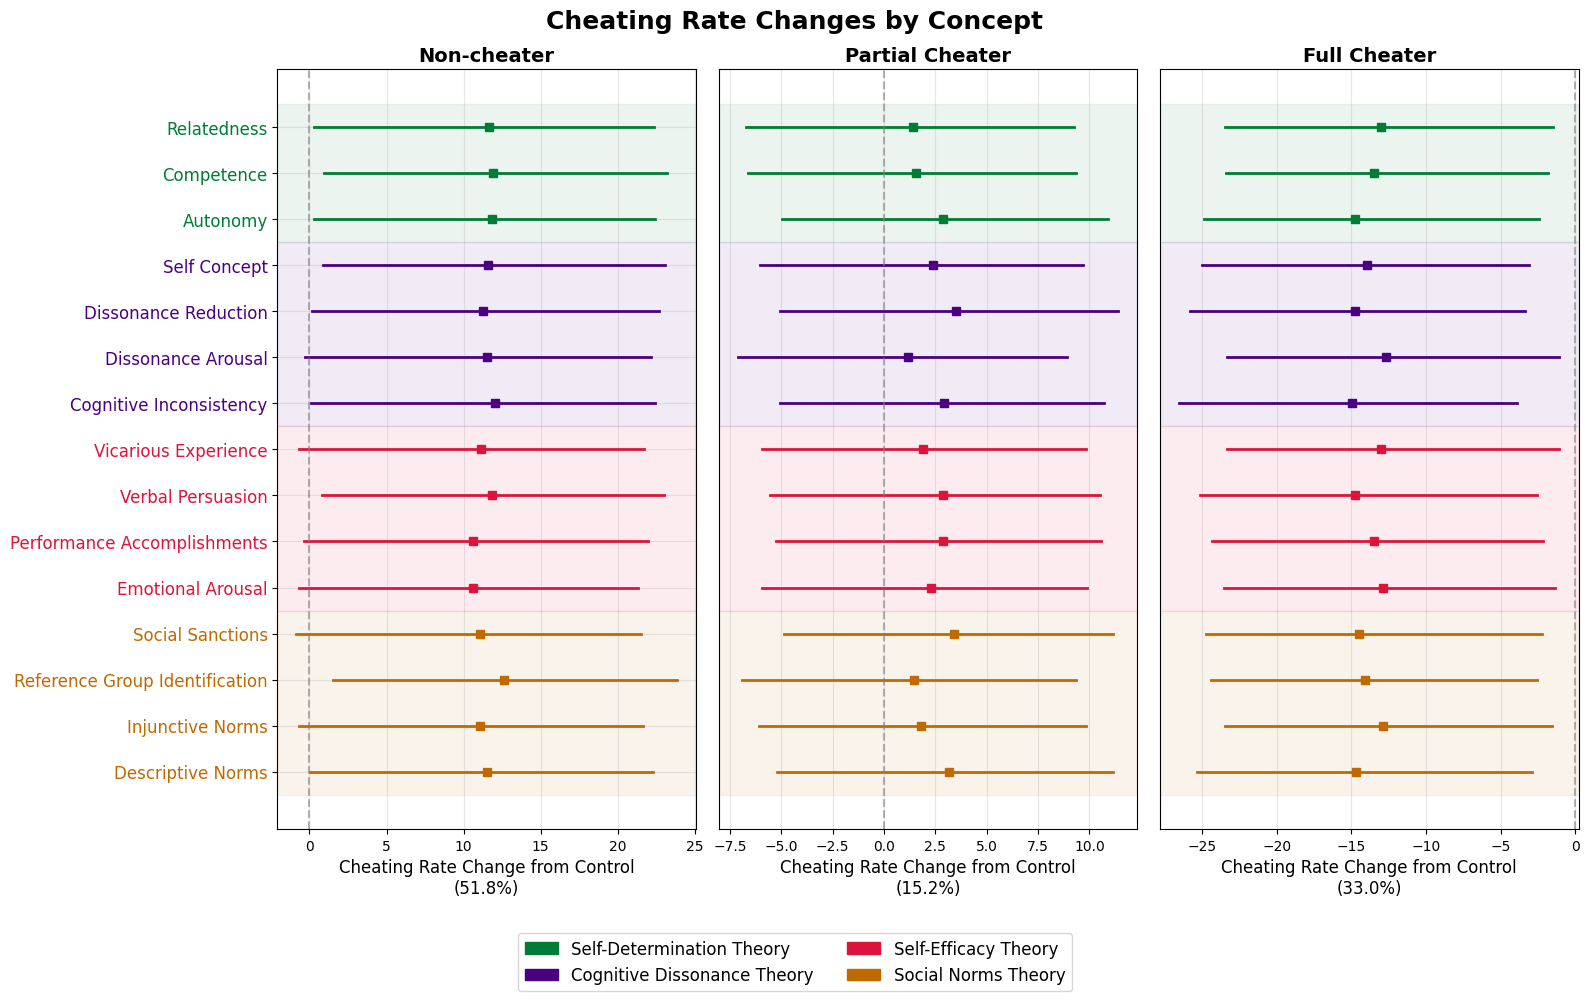

In [22]:
# =================
# FOREST PLOTS
# =================

import matplotlib.pyplot as plt
import matplotlib.patches as patches


def plot_cheating_forest(df_results, overall_results, control_baselines):
    categories = ['Non', 'Partial', 'Full']
    titles = ['Non-cheater', 'Partial Cheater', 'Full Cheater']
    outcome_name = 'Cheating Rate'
    units = 'pp'
    
    theory_order_viz = ['Social Norms Theory', 'Self-Efficacy Theory', 'Cognitive Dissonance Theory', 'Self-Determination Theory']
    theory_colors = {
        'Self-Determination Theory': "#007C36",
        'Cognitive Dissonance Theory': '#4B0082',
        'Self-Efficacy Theory': '#DC143C',
        'Social Norms Theory': "#C06900"
    }

    # ---------------- Overall Effects ----------------
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    for idx, cat in enumerate(categories):
        ax = axes[idx]
        mean = overall_results[cat]['mean']
        hdi = overall_results[cat]['hdi']
        
        ax.plot([hdi[0], hdi[1]], [0, 0], color='black', lw=3)
        ax.plot(mean, 0, 's', color='black', markersize=10)
        precision = 1 if units == 'pp' else 2
        ax.text(mean, -0.15, f'{mean:+.{precision}f}\n[{hdi[0]:+.{precision}f}, {hdi[1]:+.{precision}f}]', 
                ha='center', va='center', fontweight='bold', fontsize=12)
        
        ax.axvline(0, color='gray', linestyle='--', alpha=0.6)
        ax.set_title(titles[idx], fontsize=14, fontweight='bold')
        ax.set_xlabel(f"{outcome_name} Change from Control\n({control_baselines[cat]:.1f}%)", fontsize=12)
        
        ax.set_yticks([0])
        ax.set_yticklabels(['Overall'] if idx == 0 else [])
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-0.5, 0.5)
    plt.suptitle(f'Overall Intervention Effect on {outcome_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

    # ---------------- By-Concept Effects ----------------
    df_results['Theory'] = pd.Categorical(df_results['Theory'], categories=theory_order_viz, ordered=True)
    df_sorted = df_results.sort_values(['Theory', 'Concept']).reset_index(drop=True)
    y_pos = np.arange(len(df_sorted))

    fig, axes = plt.subplots(1, 3, figsize=(16, 10))
    for idx, cat in enumerate(categories):
        ax = axes[idx]
        means = df_sorted[f'{cat}_mean']
        hdis = np.array([x for x in df_sorted[f'{cat}_hdi']])

        # Background shading
        for theory in theory_order_viz:
            inds = df_sorted.index[df_sorted['Theory'] == theory]
            if not inds.empty:
                ax.axhspan(inds[0]-0.5, inds[-1]+0.5, color=theory_colors[theory], alpha=0.08)

        # Forest bars
        for i, (mean, hdi, theory) in enumerate(zip(means, hdis, df_sorted['Theory'])):
            color = theory_colors[theory]
            ax.plot([hdi[0], hdi[1]], [i, i], color=color, lw=2)
            ax.plot(mean, i, 's', color=color, markersize=6)

        ax.axvline(0, color='gray', linestyle='--', alpha=0.6)
        ax.set_title(titles[idx], fontsize=14, fontweight='bold')
        ax.set_xlabel(f"{outcome_name} Change from Control\n({control_baselines[cat]:.1f}%)", fontsize=12)
        ax.grid(True, alpha=0.3)
        
        if idx == 0:
            ax.set_yticks(y_pos)
            ax.set_yticklabels(df_sorted['Concept'], fontsize=12)
            for tick, theory in zip(ax.get_yticklabels(), df_sorted['Theory']):
                tick.set_color(theory_colors[theory])
        else:
            ax.set_yticks([])
    plt.suptitle(f'{outcome_name} Changes by Concept', fontsize=18, fontweight='bold', y=0.94)

    # Legend
    legend_handles = [patches.Patch(color=color, label=theory) for theory, color in theory_colors.items()]
    fig.legend(handles=legend_handles, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2, fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88, bottom=0.12)
    plt.show()
plot_cheating_forest(df_results_cheating, overall_results_cheating, control_rates)